In [1]:
import numpy as np
import importlib
import calibration
importlib.reload(calibration)
import datasets
importlib.reload(datasets)
import tensorflow as tf
from tensorflow import keras
from keras import layers
import sklearn
import sklearn.metrics
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()


2023-02-17 17:11:19.750670: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-17 17:11:19.810487: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-02-17 17:11:20.052094: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-02-17 17:11:20.053364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 17:11:21.986211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [244]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
def fix_dim(arg, n=4):
    arg = arg.copy()
    if arg.ndim == n - 1:
        arg = arg[..., np.newaxis]
    return arg

x_test = fix_dim(x_test / 255)
x_train = fix_dim(x_train / 255)
y_test = fix_dim(y_test, 2)
y_train = fix_dim(y_train, 2)

def group_in_two(y):
    inds = (y != 0) * (y != 2) * (y != 4) * (y != 5) * (y != 7)
    y[inds] = 0
    y[np.invert(inds)] = 1


group_in_two(y_train)
group_in_two(y_test)

rng = np.random.default_rng()
# rng.shuffle(x_train)
# rng.shuffle(x_test)


In [234]:
x_train, y_train = datasets.get_xor0()
x_test, y_test = x_train, y_train
input_shape = (2, )
model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(),
    layers.Dense(1, activation=keras.activations.sigmoid),
    # layers.Dense(1, use_bias=False, activation="relu")
])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 2)                 0         
                                                                 
 dense_73 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [245]:
input_shape = x_train.shape[1:]
model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(),
    # layers.Dense(1),
    # layers.Dense(4, activation=keras.activations.sigmoid),
    # layers.Dense(4, activation=keras.activations.sigmoid),
    # layers.Dense(4, activation=keras.activations.sigmoid),
    # layers.Dense(4, activation=keras.activations.sigmoid),
    layers.Dense(1),
    layers.Activation("sigmoid")
    ]
)


In [246]:
def loss_func_entropy(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = y_true[:, 0]
    eps = 1e-6
    p0 = tf.clip_by_value(1 - y_pred[:,0] + eps, 0, 1)
    p1 = tf.clip_by_value(y_pred[:,0] + eps, 0, 1)
    loss = -tf.math.xlogy(y_true, p1) - tf.math.xlogy(1 - y_true, p0)
    loss /= tf.math.log(2.0)
    return loss

# loss_func = keras.losses.mse
loss_func = loss_func_entropy
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"])
model.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 784)               0         
                                                                 
 dense_75 (Dense)            (None, 1)                 785       
                                                                 
 activation_18 (Activation)  (None, 1)                 0         
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [253]:
w = model.get_weights()
# model.layers[1].set_weights([np.array([[10.], [10.]]), np.array([-5])])
# model.layers[2].set_weights([np.array([[0.67]])])
model.optimizer.learning_rate = 0.004
model.fit(x_train, y_train, batch_size=60000, epochs=100)
y_pred = model(x_train).numpy()
np.set_printoptions(precision=3)


Epoch 1/100
1/1 [==============================] - 0s 71ms/step - loss: 0.4860 - accuracy: 0.8551
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.4860 - accuracy: 0.8552
Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 0.4860 - accuracy: 0.8552
Epoch 4/100
1/1 [==============================] - 0s 15ms/step - loss: 0.4860 - accuracy: 0.8552
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 0.4859 - accuracy: 0.8552
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 0.4859 - accuracy: 0.8552
Epoch 7/100


2023-02-17 18:12:18.057907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [60000,28,28,1]
	 [[{{node Placeholder/_10}}]]
2023-02-17 18:12:18.058263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype uint8 and shape [60000,1]
	 [[{{node Placeholder/_11}}]]


1/1 [==============================] - 0s 25ms/step - loss: 0.4859 - accuracy: 0.8552
Epoch 8/100
1/1 [==============================] - 0s 19ms/step - loss: 0.4859 - accuracy: 0.8552
Epoch 9/100
1/1 [==============================] - 0s 20ms/step - loss: 0.4859 - accuracy: 0.8552
Epoch 10/100
1/1 [==============================] - 0s 21ms/step - loss: 0.4859 - accuracy: 0.8552
Epoch 11/100
1/1 [==============================] - 0s 20ms/step - loss: 0.4859 - accuracy: 0.8552
Epoch 12/100
1/1 [==============================] - 0s 24ms/step - loss: 0.4859 - accuracy: 0.8552
Epoch 13/100
1/1 [==============================] - 0s 20ms/step - loss: 0.4858 - accuracy: 0.8552
Epoch 14/100
1/1 [==============================] - 0s 24ms/step - loss: 0.4858 - accuracy: 0.8553
Epoch 15/100
1/1 [==============================] - 0s 19ms/step - loss: 0.4858 - accuracy: 0.8553
Epoch 16/100
1/1 [==============================] - 0s 20ms/step - loss: 0.4858 - accuracy: 0.8552
Epoch 17/100
1/1 [=======

In [254]:
def print_res(x, y_true, name):
    scores = model(x).numpy()
    y_pred = scores >= 0.5
    loss = loss_func(y_true, scores).numpy()
    loss_av = np.average(loss)
    e_loss = loss_func_entropy(y_true, scores)
    e_loss_av = np.average(e_loss)
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    entropy = calibration.get_binary_entropy(y_true)
    print(f"{name}  entropy={entropy:.4} accuracy={accuracy:.4} loss={loss_av:.4} entropy_loss={e_loss_av:.4}")

print_res(x_train, y_train, "train")
print_res(x_test, y_test, "test")


train  entropy=1.0 accuracy=0.8558 loss=0.4847 entropy_loss=0.4847
test  entropy=1.0 accuracy=0.8526 loss=0.4965 entropy_loss=0.4965


***** train ******


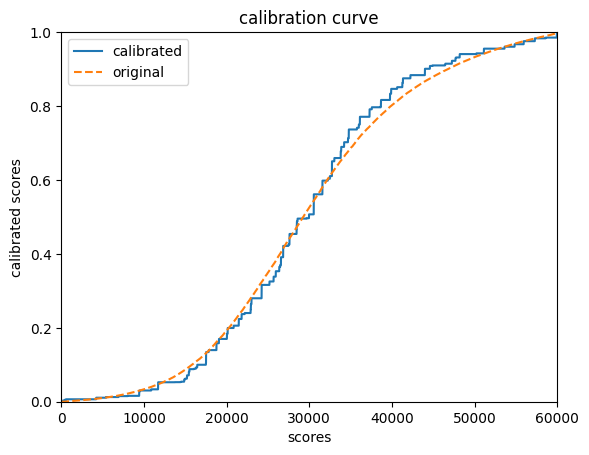

loss=0.4847 loss_calib=0.4806 accuracy=0.8558
***** test ******


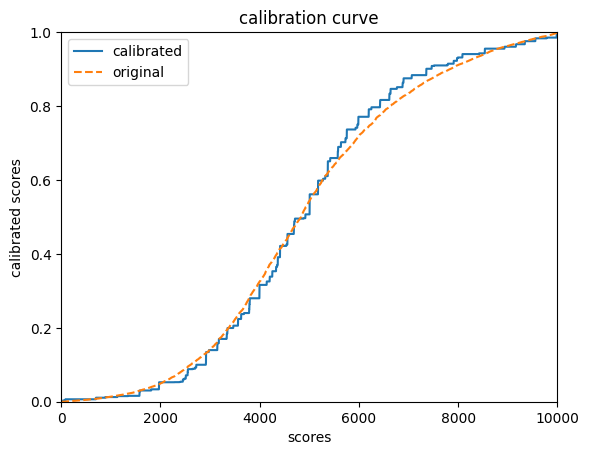

loss=0.4965 loss_calib=0.4953 accuracy=0.8526


In [255]:
scores_train = model(x_train).numpy()
calib_func = calibration.get_calibration_function(y_train.squeeze(1), scores_train.squeeze(1))

def print_calib(x, y_true, name):
    print(f"***** {name} ******")
    scores = model(x).numpy().squeeze(1)
    y_pred = scores >= 0.5
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    calib_scores = np.vectorize(calib_func)(scores).astype(np.float32)
    calibration.plot_calibrated_curve(scores, calib_scores)
    loss = loss_func(y_true, scores[:, None])
    loss_calib = loss_func(y_true, calib_scores[:, None])
    print(f"loss={np.average(loss):.4} loss_calib={np.average(loss_calib):.4} accuracy={accuracy:.4}")

print_calib(x_train, y_train, "train")
print_calib(x_test, y_test, "test")



In [64]:
w = model.weights
w0 = w[0].numpy()
w1 = w[1].numpy()

In [1]:
import sys
print(sys.version)
d = {"aa": 3, "bb": 5}
print(d["aab"] + d["bb"])

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


KeyError: 'aab'